In [1]:
import gdal
import glob

In [2]:
files = glob.glob('./data/MOD16_ET/*/*.tiff')

In [3]:
ETs = []
huc8s = []
years =[]
months = []
areas = []
cells = []

for fl in files:
    # extract some data from the filenames
    huc8s.append(int(fl.split('/')[-1].split('.')[-2].split('_')[-1]))
    years.append(int(fl.split('/')[-1].split('.')[-2].split('_')[-3].split('M')[-2].split('A')[-1]))
    months.append(int(fl.split('/')[-1].split('.')[-2].split('_')[-3].split('M')[-1]))
    
    # open the data source
    ds = gdal.Open(fl,gdal.GA_ReadOnly)
    rast = np.array(ds.GetRasterBand(1).ReadAsArray(),dtype=np.float64)
    
    nans = np.isnan(rast)
    k,l = nans.shape
    nans.shape = (1,k*l) # reshape

    rast[rast>32700] = np.NaN # remove no data values
    rast*=0.1 # scale to mm/month

    
    # reshape the array
    n,m = rast.shape
    rast.shape=(1,n*m)
    
    cell = (m*n) - np.sum(nans) # count the number of watershed cells
    area = cell*(500*500) # area in m^2
    
    # sum and append monthly ET
    ETs.append(np.nansum(rast)/cell) # ET mm/m^2/month
    cells.append(cell)
    areas.append(area)
    

dat = pd.DataFrame({'huc8':huc8s,'year':years,'month':months,'ET':ETs,'area':areas,'cells':cells})

In [4]:
def compute_datetime(df):
    month=df.month
    year=df.year
    
    return pd.datetime(int(year),int(month),15)

In [5]:
dat['datetime'] = dat.apply(compute_datetime,axis=1)

In [6]:
dat.index = pd.DatetimeIndex(dat.datetime)

In [7]:
dat['wateryear'] = dat.index.map(rut.wateryear)

In [8]:
dat.to_pickle('./data/mod16_ET_huc8.pcl')

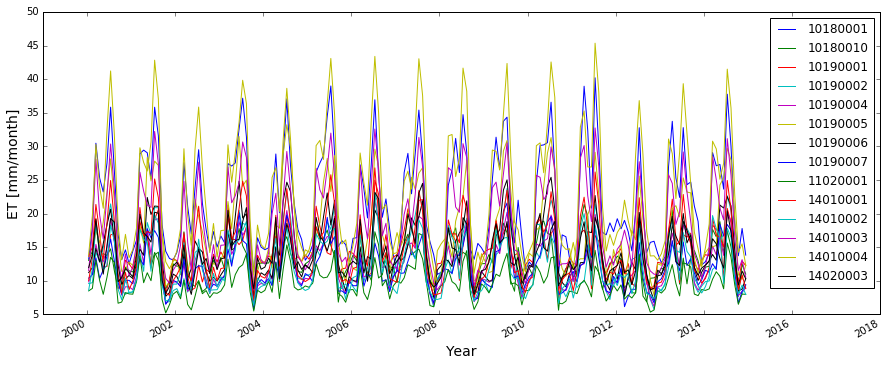

In [9]:
dat.groupby(by='huc8').ET.plot(figsize=(15,6));
plt.xlim('1999','2018')
#plt.ylim(0,50)
plt.legend()
plt.ylabel('ET [mm/month]', fontsize=14)
plt.xlabel('Year', fontsize=14)